# Libraries

In [30]:
# Import libraries

from os import listdir
import string
import pandas as pd
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import warnings
import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# Loading data

In [19]:
# load doc into memory
def load_doc(filename):
	file = open(filename, encoding='utf-8')
	text = file.read()
	file.close()
	return text

# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = []
    highlights =[]
    for name in listdir(directory[:10000]):
        filename = directory + '/' + name
		# load document
        doc = load_doc(filename)
		# split into story and highlights
        story, highlight = split_story(doc)
		# store
        stories.append(story)
        highlights.append(highlight)
    data = pd.DataFrame()
    data["story"] = stories
    data["highlight"] = highlights
    
    return  data

In [20]:
# load stories
directory = r"C:\Users\feder\Desktop\cnn\stories/"
data = load_stories(directory)



In [21]:
print('Loaded Stories %d' % len(data))

Loaded Stories 32103


# Cleaning and preprocessing


In [22]:
data.head()

,story,highlight
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria.\n\nObama sent a letter to the heads of the House and Senate on Saturday night, hou...","[Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down"", Obama sends a letter to the heads of the House and Senate, Obama to seek congressional approval on military ..."
1,"While Labor Day is the unofficial end of summer, it's also the unofficial start to the campaign season.\n\nThat means politicking will be on the rise, especially as control of the Senate is at sta...","[Labor Day is the unofficial end of summer and the unofficial start to campaign season, As much as $3.4 billion could be spent on advertising for this midterm election, Here are five must-follow r..."
2,"Gaza City (CNN) -- An Italian humanitarian activist and journalist who was kidnapped in Gaza has been found dead and one person is in custody, the Hamas Interior Ministry said Friday in a statemen...","[NEW: Autopsy indicates he had been dead for hours before police arrived, YouTube video appears to show the activist bound and blindfolded, The activist and freelance journalist was from the Lomba..."
3,"(CNN) -- Renowned radio personality Casey Kasem is in critical condition at a hospital in western Washington, a spokesman for St. Anthony Hospital told CNN in a written statement Thursday.\n\n""Mr....","[The radio personality was taken to a hospital Sunday, Spokesman for hospital says Casey Kasem being treated for wounds, blood pressure issues, He had been at a friend's home in Washington state a..."
4,"(CNN)For the second time during his papacy, Pope Francis has announced a new group of bishops and archbishops set to become cardinals -- and they come from all over the world.\n\nPope Francis said...","[The 15 new cardinals will be installed on February 14, They come from countries such as Myanmar and Tonga, No Americans made the list this time or the previous time in Francis' papacy]"


In [23]:
data = data.explode("highlight")

## Normalization

In [24]:
stop_words = set(stopwords.words('english')) 

def remove_non_ascii(words):
    """Remove non-ASCII characters"""
    new_words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase"""
    new_words = words.lower()
    return new_words

def remove_punctuation(words):
    """Remove punctuation"""
    new_words = re.sub(r'\([^)]*\)', '', words)
    return new_words

def replace_numbers(words):
    """Replace all integer occurrences"""
    new_words = re.sub("[^a-zA-Z]", " ", words) 
    return new_words

def remove_stopwords(words):
    """Remove stop words"""
    new_words = [w for w in words.split() if not w in stop_words]
    long_words=[]
    for i in new_words:
        if len(i)>=1:                  
            long_words.append(i)   

    return (" ".join(long_words)).strip()


def replace_contractions(words):
    """Replace contractions in string of text"""
    return contractions.fix(words)

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = replace_contractions(words)
    words = remove_stopwords(words)

    return words

In [25]:
#Call the above function

cleaned_story = []
for t in data['story']:
    cleaned_story.append(normalize(t))

cleaned_highlight = []
for t in data['highlight']:
    cleaned_highlight.append(normalize(t))

data['normalized_text']=cleaned_story
data['normalized_highlight']=cleaned_highlight
data['normalized_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Lemmatization

In [31]:
def lemmatize(words):
    words = lemmatizer.lemmatize(words)
    return words

In [32]:
#Call the above function

lemmatized_story = []
for t in data['normalized_text']:
    lemmatized_story.append(lemmatize(t))
    
lemmatized_highlight = []
for t in data['normalized_highlight']:
    lemmatized_highlight.append(lemmatize(t))

data['cleaned_text']=lemmatized_story
data['cleaned_highlight']=lemmatized_highlight
data['cleaned_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Add start and end tokens for the summarizer

In [33]:
data['cleaned_highlight'] = data['cleaned_highlight'].apply(lambda x : 'starttoken '+ x + ' endtoken')


## Visualize results

In [34]:
data = data[["cleaned_text", "cleaned_highlight"]]
data

,cleaned_text,cleaned_highlight
0,official president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets ...,starttoken syrian official obama climbed top tree know get endtoken
0,official president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets ...,starttoken obama sends letter heads house senate endtoken
0,official president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets ...,starttoken obama seek congressional approval military action syria endtoken
0,official president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets ...,starttoken aim determine whether cw used says n spokesman endtoken
1,labor day unofficial end summer also unofficial start campaign season means politicking rise especially control senate stake well control state houses turn tv expect see nastier political advertis...,starttoken labor day unofficial end summer unofficial start campaign season endtoken
...,...,...
32101,norfolk virginia second mate houston express probably believe seeing hundreds miles land small boat nearby first looked abandoned bad shape listing one side crew foot long container ship thought y...,starttoken louis jordan found sailboat listing bad shape rescuer says endtoken
32101,norfolk virginia second mate houston express probably believe seeing hundreds miles land small boat nearby first looked abandoned bad shape listing one side crew foot long container ship thought y...,starttoken appears good shape physically mentally endtoken
32102,tired counting sheep try one remedies get good night sleep aromatherapy try drowsy slightly tense use massage dab aromatherapeutic balm oil back neck shoulders hit sack certain fragrances includin...,starttoken fragrances make feel calm lavender lemon balm help sleep endtoken
32102,tired counting sheep try one remedies get good night sleep aromatherapy try drowsy slightly tense use massage dab aromatherapeutic balm oil back neck shoulders hit sack certain fragrances includin...,starttoken take counter sleeping pills sparingly could build tolerance endtoken


## Dataset splitting

In [15]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_highlight'],test_size=0.1,random_state=0,shuffle=True) 

## Tokenization

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [17]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 20.840642228109115
Total Coverage of rare words: 0.11403927714797595


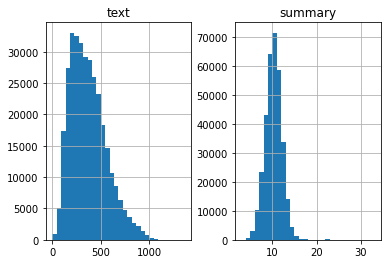

In [18]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlight']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [19]:
cnt=0
for i in data['cleaned_highlight']:
    if(len(i.split())<=14):
        cnt=cnt+1
print(cnt/len(data['cleaned_highlight']))

0.9933370366660292


In [20]:
max_text_len=500
max_summary_len=15

In [21]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)


In [22]:
#padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

In [23]:
x_voc

-103765

In [24]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [25]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 65.77302727644413
Total Coverage of rare words: 2.9962405546704463


In [26]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1


In [27]:
y_voc

23441

In [28]:
y_tokenizer.word_counts['starttoken'],len(y_tr)


(296489, 296489)

In [29]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [30]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Saving the data

In [31]:
np.save("final_data/x_tr.npy", x_tr)
np.save("final_data/y_tr.npy", y_tr)
np.save("final_data/x_val.npy", x_val)
np.save("final_data/y_val.npy", y_val)


In [32]:
import pickle

# saving
with open('y_tokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Load data

In [33]:
x_tr = np.load("final_data/x_tr.npy")
y_tr = np.load("final_data/y_tr.npy")
x_val = np.load("final_data/x_val.npy")
y_val = np.load("final_data/y_val.npy")

In [34]:
def open_test_data():
    return open('y_tokenizer.pickle', 'rb')

with open_test_data() as f:
    y_tokenizer = pickle.load(f) 

# Modeling

In [37]:
from tensorflow.keras import backend as K 
K.clear_session()

latent_dim = 100
embedding_dim=100

# Encoder

encoder_inputs = Input(shape=(max_text_len,))
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)

# Decoder

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      204500      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [39]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=10, verbose = 1,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[112,1] = 5337 is not in [0, 3)
	 [[node model/embedding_1/embedding_lookup (defined at <ipython-input-39-25819d734f80>:1) ]]
	 [[model/embedding/embedding_lookup/_28]]
  (1) Invalid argument:  indices[112,1] = 5337 is not in [0, 3)
	 [[node model/embedding_1/embedding_lookup (defined at <ipython-input-39-25819d734f80>:1) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_16212]

Errors may have originated from an input operation.
Input Source operations connected to node model/embedding_1/embedding_lookup:
 model/embedding_1/embedding_lookup/10103 (defined at C:\Users\feder\.conda\envs\nlp\lib\contextlib.py:113)

Input Source operations connected to node model/embedding_1/embedding_lookup:
 model/embedding_1/embedding_lookup/10103 (defined at C:\Users\feder\.conda\envs\nlp\lib\contextlib.py:113)

Function call stack:
train_function -> train_function


In [ ]:
model.save_weights("weights.h5")

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# Inference

In [ ]:
model.load_weights("weights.h5")

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['starttoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starttoken']) and i!=target_word_index['endtoken']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,30):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")